In [2]:
%conda install pandas numpy scikit-learn beautifulsoup4 requests shap seaborn matplotlib -y

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/vladdenisov/miniconda3/envs/phishy

  added / updated specs:
    - beautifulsoup4
    - matplotlib
    - numpy
    - pandas
    - requests
    - scikit-learn
    - seaborn
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.12.3      |     pyha770c72_0         115 KB  conda-forge
    brotli-python-1.1.0        |  py311h3f08180_2         332 KB  conda-forge
    cffi-1.17.1                |  py311h3a79f62_0         281 KB  conda-forge
    charset-normalizer-3.4.0   |     pyhd8ed1ab_0          46 KB  conda-forge
    cloudpickle-3.1.0          |     pyhd8ed1ab_1          25 KB  conda-forge
    colorama-0.4.6             |     pyhd8ed1ab_0          25 KB  conda-forge
    h2-4.1.0                   |     pyhd8ed1ab_0          46 KB  co

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse
import re
import warnings
from sklearn.metrics import classification_report
import shap
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup
import re
import shap
from typing import List, Dict, Union, Tuple
import logging


class HTMLPhishingDetector:
    def __init__(self, n_estimators: int = 100, random_state: int = 42):
        """
        Initialize the phishing detector with configurable parameters.

        Args:
            n_estimators: Number of trees in RandomForest (default: 100)
            random_state: Random seed for reproducibility (default: 42)
        """
        self.model = RandomForestClassifier(
            n_estimators=n_estimators, random_state=random_state)
        self.scaler = StandardScaler()
        self.feature_names: List[str] = []
        self.explainer = None

        # Configure logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def extract_html_features(self, html_content: str) -> np.ndarray:
        """
        Extract features from HTML content for phishing detection.

        Args:
            html_content: Raw HTML string

        Returns:
            np.ndarray: Array of extracted feature values

        Raises:
            ValueError: If HTML content is empty or invalid
        """
        if not html_content or not isinstance(html_content, str):
            raise ValueError("HTML content must be a non-empty string")

        try:
            features = {}
            soup = BeautifulSoup(html_content, 'html.parser')

            # Form-related features
            forms = soup.find_all('form')
            features['form_count'] = len(forms)
            features['password_fields'] = len(
                soup.find_all('input', {'type': 'password'}))
            features['external_form_actions'] = sum(1 for form in forms
                                                    if form.get('action', '').startswith(('http', '//')))

            # Link analysis with improved external link detection
            links = soup.find_all('a')
            features['link_count'] = len(links)

            external_links = 0
            internal_links = 0
            for link in links:
                href = link.get('href', '').strip()
                if href.startswith(('http', '//', 'www.')):
                    external_links += 1
                elif href and not href.startswith('#'):  # Ignore anchor links
                    internal_links += 1

            total_links = external_links + internal_links
            features['external_links_ratio'] = (
                external_links / (total_links + 1)) if total_links > 0 else 0

            # Enhanced script analysis
            scripts = soup.find_all('script')
            features['script_count'] = len(scripts)
            features['external_scripts'] = sum(1 for script in scripts
                                               if script.get('src', '').startswith(('http', '//')))

            # Meta tag and favicon analysis
            features['meta_tag_count'] = len(soup.find_all('meta'))
            features['has_favicon'] = int(bool(
                soup.find('link', rel=re.compile(
                    r'^(shortcut\s+)?icon$', re.I))
            ))

            # Hidden elements detection (improved regex)
            hidden_pattern = re.compile(
                r'display\s*:\s*none|visibility\s*:\s*hidden', re.I)
            hidden_elements = soup.find_all(['input', 'div', 'span'],
                                            style=hidden_pattern)
            features['hidden_element_count'] = len(hidden_elements)

            # Enhanced security indicators
            features['has_https_link'] = int(
                bool(soup.find('a', href=re.compile(r'^https://'))))

            # Improved security text detection
            security_pattern = re.compile(
                r'security|secure|login|sign.?in|verify|confirm|update|account', re.I
            )
            features['has_security_text'] = int(
                bool(re.search(security_pattern, html_content)))

            # Content analysis with improved text extraction
            text_content = ' '.join(soup.stripped_strings).lower()
            features['text_length'] = len(text_content)

            # Enhanced urgent text detection
            urgent_pattern = re.compile(
                r'urgent|immediate|action\s+required|verify.?account|limited.?time|expires?|deadline', re.I
            )
            features['has_urgent_text'] = int(
                bool(re.search(urgent_pattern, text_content)))

            # Enhanced input field analysis
            input_fields = soup.find_all('input')
            features['input_field_count'] = len(input_fields)

            sensitive_types = {'password', 'email', 'tel',
                               'credit-card', 'card-number', 'ssn'}
            features['sensitive_input_count'] = sum(
                1 for field in input_fields
                if field.get('type', '').lower() in sensitive_types
                or any(term in field.get('name', '').lower() for term in sensitive_types)
            )

            return np.array(list(features.values()))

        except Exception as e:
            self.logger.error(f"Error extracting features: {str(e)}")
            raise

    def prepare_dataset(self, html_contents: List[str], labels: List[int]) -> np.ndarray:
        """
        Prepare features from multiple HTML contents.

        Args:
            html_contents: List of HTML strings
            labels: List of corresponding labels (0 for legitimate, 1 for phishing)

        Returns:
            np.ndarray: Feature matrix

        Raises:
            ValueError: If inputs are invalid or mismatched
        """
        if len(html_contents) != len(labels):
            raise ValueError(
                "Number of HTML contents must match number of labels")

        features_list = []
        for i, html in enumerate(html_contents):
            try:
                features_list.append(self.extract_html_features(html))
            except Exception as e:
                self.logger.warning(
                    f"Failed to extract features for sample {i}: {str(e)}")
                continue

        features_array = np.array(features_list)

        self.feature_names = [
            'form_count', 'password_fields', 'external_form_actions',
            'link_count', 'external_links_ratio', 'script_count',
            'external_scripts', 'meta_tag_count', 'has_favicon',
            'hidden_element_count', 'has_https_link', 'has_security_text',
            'text_length', 'has_urgent_text', 'input_field_count',
            'sensitive_input_count'
        ]

        return features_array

    def train(self, X: np.ndarray, y: np.ndarray) -> 'HTMLPhishingDetector':
        """
        Train the phishing detection model.

        Args:
            X: Feature matrix
            y: Target labels

        Returns:
            self: Trained model instance

        Raises:
            ValueError: If input shapes are invalid
        """
        if X.shape[1] != len(self.feature_names):
            raise ValueError(
                f"Expected {len(self.feature_names)} features, got {X.shape[1]}")

        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Train model
        self.model.fit(X_scaled, y)

        # Initialize SHAP explainer
        try:
            self.explainer = shap.TreeExplainer(self.model)
        except Exception as e:
            self.logger.warning(
                f"Failed to initialize SHAP explainer: {str(e)}")
            self.explainer = None

        return self

    def predict(self, html_content: str) -> Dict[str, Union[bool, float, str, List]]:
        """
        Predict whether HTML content is from a phishing page and explain why.

        Args:
            html_content: HTML string to analyze

        Returns:
            Dict containing prediction results and explanations
        """
        try:
            # Extract and scale features
            features = self.extract_html_features(html_content)
            features_scaled = self.scaler.transform(features.reshape(1, -1))

            # Make prediction
            prediction = self.model.predict(features_scaled)[0]
            probability = self.model.predict_proba(features_scaled)[0]

            # Generate explanation
            explanation = "No explanation available"
            feature_importance = []

            if self.explainer:
                try:
                    shap_values = self.explainer.shap_values(features_scaled)

                    # Handle different SHAP value formats
                    if isinstance(shap_values, list):
                        shap_vals = shap_values[1][0] if prediction == 1 else shap_values[0][0]
                    else:
                        shap_vals = shap_values[0]

                    # Ensure shap_vals is 1D
                    if isinstance(shap_vals, np.ndarray) and shap_vals.ndim > 1:
                        shap_vals = shap_vals.flatten()

                    explanation = self._generate_explanation(
                        features, shap_vals)
                    feature_importance = self._get_feature_importance(
                        features, shap_vals)
                except Exception as e:
                    self.logger.warning(
                        f"Failed to generate SHAP explanation: {str(e)}")
                    feature_importance = []

            suspicious_elements = self._identify_suspicious_elements(
                html_content)

            return {
                'is_phishing': bool(prediction),
                'confidence': float(max(probability)),
                'explanation': explanation,
                'feature_importance': feature_importance[:5] if feature_importance else [],
                'suspicious_elements': suspicious_elements
            }

        except Exception as e:
            self.logger.error(f"Prediction error: {str(e)}")
            raise

    def _generate_explanation(self, features: np.ndarray, shap_values: np.ndarray) -> str:
        """Generate detailed human-readable explanation based on SHAP values."""
        feature_importance = self._get_feature_importance(
            features, shap_values)
        
        print(feature_importance)

        explanations = []
        for feature, value, importance in feature_importance[:5]:
            if abs(importance) < 0.01:
                continue

            if feature == 'external_links_ratio':
                explanations.append(
                    f"The ratio of external links ({value:.2f}) is "
                    f"{'unusually high' if importance > 0 else 'normal'}"
                )
            elif feature == 'password_fields':
                explanations.append(
                    f"The number of password fields ({int(value)}) is "
                    f"{'suspicious' if importance > 0 else 'normal'}"
                )
            elif feature == 'hidden_element_count':
                explanations.append(
                    f"The number of hidden elements ({int(value)}) is "
                    f"{'suspicious' if importance > 0 else 'normal'}"
                )
            elif feature == 'has_urgent_text' and value == 1:
                explanations.append(
                    "The page contains urgent or threatening language")
            elif feature == 'sensitive_input_count':
                explanations.append(
                    f"The number of sensitive input fields ({int(value)}) is "
                    f"{'suspicious' if importance > 0 else 'normal'}"
                )

        return ' and '.join(explanations) + '.' if explanations else "No significant suspicious patterns found."

    def _get_feature_importance(
        self,
        features: np.ndarray,
        shap_values: np.ndarray
    ) -> List[Tuple[str, float, float]]:
        """Calculate feature importance using SHAP values."""
        feature_importance = []

        for name, value, importance in zip(self.feature_names, features, shap_values):
            # Safely convert numpy values to Python scalars
            if isinstance(value, np.ndarray):
                value = value.mean() if value.size > 1 else value.item()
            if isinstance(importance, np.ndarray):
                importance = importance.mean() if importance.size > 1 else importance.item()

            feature_importance.append((name, float(value), float(importance)))
        
        print(feature_importance)

        return sorted(feature_importance, key=lambda x: abs(x[2]), reverse=True)

    def _identify_suspicious_elements(self, html_content: str) -> List[Dict[str, str]]:
        """
        Identify specific suspicious elements in the HTML content.

        Args:
            html_content: HTML string to analyze

        Returns:
            List of suspicious elements with their types and issues
        """
        try:
            soup = BeautifulSoup(html_content, 'html.parser')
            suspicious = []

            # Check for forms with external actions
            for form in soup.find_all('form'):
                action = form.get('action', '')
                if action.startswith(('http', '//')):
                    suspicious.append({
                        'type': 'form',
                        'issue': 'External form action',
                        'element': str(form)[:200] + '...' if len(str(form)) > 200 else str(form)
                    })

            # Enhanced hidden field detection
            hidden_fields = soup.find_all('input', {'type': 'hidden'})
            sensitive_patterns = re.compile(
                r'pass|credit|card|cvv|ssn|social|security|account', re.I)

            for field in hidden_fields:
                name = field.get('name', '').lower()
                value = field.get('value', '').lower()

                if sensitive_patterns.search(name) or sensitive_patterns.search(value):
                    suspicious.append({
                        'type': 'hidden_field',
                        'issue': 'Suspicious hidden field name/value',
                        'element': str(field)
                    })

            # Enhanced script analysis
            script_patterns = re.compile(
                r'document\.cookie|password|creditcard|logger|steal|inject|exploit', re.I
            )

            for script in soup.find_all('script'):
                content = script.string if script.string else ''
                if content and script_patterns.search(content):
                    suspicious.append({
                        'type': 'script',
                        'issue': 'Suspicious script content',
                        'element': str(script)[:200] + '...' if len(str(script)) > 200 else str(script)
                    })

            return suspicious

        except Exception as e:
            self.logger.error(
                f"Error identifying suspicious elements: {str(e)}")
            return []

In [3]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer
from bs4 import BeautifulSoup
import numpy as np

In [20]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer
from bs4 import BeautifulSoup
import numpy as np

class BERTPhishingDetector(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', num_html_features=16):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)
        self.num_html_features = num_html_features
        
        # Combined features dimension
        bert_hidden_size = self.bert.config.hidden_size
        combined_size = bert_hidden_size + num_html_features
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(combined_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input_ids, attention_mask, html_features):
        # Process text through BERT
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Get [CLS] token representation
        cls_output = bert_output.last_hidden_state[:, 0, :]
        
        # Combine BERT and HTML features
        combined = torch.cat((cls_output, html_features), dim=1)
        
        # Final classification
        return self.classifier(combined)

class BERTPhishingTrainer:
    def __init__(self, device='mps' if torch.backends.mps.is_available() else 'cpu'):
        self.model = BERTPhishingDetector()
        self.device = device
        self.model.to(device)
        self.html_extractor = HTMLPhishingDetector()  # Reuse feature extraction
        
    def prepare_features(self, html_content):
        """Extract both BERT and HTML features."""
        # Extract HTML features
        html_features = self.html_extractor.extract_html_features(html_content)
        
        # Extract text content
        soup = BeautifulSoup(html_content, 'html.parser')
        text = ' '.join(soup.stripped_strings)
        
        # Tokenize text
        encoded = self.model.tokenizer(
            text,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoded['input_ids'].to(self.device),
            'attention_mask': encoded['attention_mask'].to(self.device),
            'html_features': torch.tensor(html_features, dtype=torch.float32).to(self.device)
        }
        
    def train(self, train_dataloader, num_epochs=3, learning_rate=2e-5):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            correct = 0
            total = 0

            print(f"Epoch {epoch+1} - Training...")

            batch_idx = 0
            max_batches = len(train_dataloader)
            
            for batch in train_dataloader:
                optimizer.zero_grad()
                
                # Move batch to device
                batch = {k: v.to(self.device) for k, v in batch.items()}
                
                outputs = self.model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    html_features=batch['html_features']
                )
                
                loss = criterion(outputs.squeeze(), batch['labels'])
                loss.backward()
                optimizer.step()
                
                # Calculate accuracy
                predictions = (outputs.squeeze() > 0.5).float()
                correct += (predictions == batch['labels']).sum().item()
                total += len(batch['labels'])
                total_loss += loss.item()
                batch_idx += 1
                if (batch_idx % 5 == 0):
                    print(f"New batch - Loss: {loss.item():.4f} - {batch_idx}/{max_batches}")
            
            scheduler.step()
            accuracy = correct / total
            avg_loss = total_loss / len(train_dataloader)
            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    def predict(self, html_content):
        self.model.eval()
        features = self.prepare_features(html_content)
        
        with torch.no_grad():
            output = self.model(
                input_ids=features['input_ids'],
                attention_mask=features['attention_mask'],
                html_features=features['html_features'].unsqueeze(0)
            )
        
        probability = output.item()
        return {
            'is_phishing': probability > 0.5,
            'confidence': probability
        }

# Example usage:
class PhishingDataset(torch.utils.data.Dataset):
    def __init__(self, html_contents, labels, tokenizer, html_extractor, max_length=512):
        self.html_contents = html_contents
        self.labels = labels
        self.tokenizer = tokenizer
        self.html_extractor = html_extractor
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        html = self.html_contents[idx]
        label = self.labels[idx]
        
        # Extract HTML features
        html_features = self.html_extractor.extract_html_features(html)
        
        # Extract and tokenize text
        soup = BeautifulSoup(html, 'html.parser')
        text = ' '.join(soup.stripped_strings)
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'html_features': torch.tensor(html_features, dtype=torch.float32),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

def prepare_dataset(html_contents, labels, tokenizer, html_extractor, batch_size=16):
    dataset = PhishingDataset(html_contents, labels, tokenizer, html_extractor)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=None
    )

In [25]:
import json
data = json.load(open('webs.json', 'r', encoding='utf-8'))[:2000]

In [26]:
html_contents = [item['text'] for item in data]
labels = [item['label'] for item in data]

In [27]:
# Initialize trainer
trainer = BERTPhishingTrainer()

# Prepare dataset
train_dataloader = prepare_dataset(
    html_contents, 
    labels, 
    trainer.model.tokenizer,
    trainer.html_extractor,
    batch_size=16
)

print(f"Dataset size: {len(labels)} samples")

# Train
trainer.train(train_dataloader, num_epochs=3)

# Save model
torch.save(trainer.model.state_dict(), 'bert_phishing_model.pth')

Dataset size: 2000 samples
Epoch 1 - Training...
New batch - Loss: 1.2908 - 5/125
New batch - Loss: 0.9689 - 10/125
New batch - Loss: 0.5997 - 15/125
New batch - Loss: 1.5183 - 20/125
New batch - Loss: 0.2798 - 25/125
New batch - Loss: 1.0382 - 30/125
New batch - Loss: 1.0506 - 35/125
New batch - Loss: 1.5869 - 40/125
New batch - Loss: 1.4073 - 45/125
New batch - Loss: 1.2735 - 50/125
New batch - Loss: 1.8129 - 55/125
New batch - Loss: 0.7045 - 60/125
New batch - Loss: 0.4051 - 65/125
New batch - Loss: 0.6435 - 70/125
New batch - Loss: 0.3906 - 75/125
New batch - Loss: 0.8934 - 80/125
New batch - Loss: 0.5912 - 85/125
New batch - Loss: 1.2551 - 90/125
New batch - Loss: 1.4059 - 95/125
New batch - Loss: 0.4118 - 100/125
New batch - Loss: 0.3782 - 105/125
New batch - Loss: 1.1544 - 110/125
New batch - Loss: 0.7222 - 115/125
New batch - Loss: 0.5494 - 120/125
New batch - Loss: 0.2837 - 125/125
Epoch 1 - Loss: 1.4707, Accuracy: 0.7035
Epoch 2 - Training...
New batch - Loss: 1.2673 - 5/125


In [28]:
sample_html = """
<!doctypehtml><html data-adblockkey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBANDrp2lz7AOmADaN8tA50LsWcjLFyQFcb/P2Txc58oYOeILb3vBw7J6f4pamkAQVSQuqYsKx3YzdUHCvbVZvFUsCAwEAAQ==_u/Y76ehgI958/G1ohB5LLs53x0pJEuQ6DPrvxbWgf7gH+RIotXeyd4kIEmsKxEyq40lD/4e3+hcXjjdu0dn52A== lang=en><meta charset=utf-8><meta content=width=device-width,initial-scale=1 name=viewport><link rel=\"shortcut icon\"href=/favicon.ico type=image/x-icon><link crossorigin href=https://www.google.com rel=preconnect><link crossorigin href=https://parking.bodiscdn.com rel=dns-prefetch><link crossorigin href=https://fonts.googleapis.com rel=dns-prefetch><body><div style=\"opacity: 0\"id=target></div><script>window.park = \"eyJ1dWlkIjoiN2VkYmYwMjUtMGY1YS03ZWEyLTljZTItYzcwNDhlZDA4NzIyIiwicGFnZV90aW1lIjoxNjM1NzA4NzgzLCJwYWdlX3VybCI6Imh0dHA6XC9cL3d3MS5rb2RpY29tbXVuaXR5LmNvbVwvIiwicGFnZV9tZXRob2QiOiJHRVQiLCJwYWdlX3JlcXVlc3QiOltdLCJwYWdlX2hlYWRlcnMiOnsiY29ubmVjdGlvbiI6WyJrZWVwLWFsaXZlIl0sImFjY2VwdCI6WyIqXC8qIl0sImFjY2VwdC1lbmNvZGluZyI6WyJnemlwLCBkZWZsYXRlIl0sInVzZXItYWdlbnQiOlsicHl0aG9uLXJlcXVlc3RzXC8yLjIxLjAiXSwiaG9zdCI6WyJ3dzEua29kaWNvbW11bml0eS5jb20iXX0sImhvc3QiOiJ3dzEua29kaWNvbW11bml0eS5jb20iLCJpcCI6IjM0Ljc2LjE4MC40In0=\";</script><script src=/js/parking.2.72.5.js></script>
"""
result = trainer.predict(sample_html)
print(f"Is phishing: {result['is_phishing']}")
print(f"Confidence: {result['confidence']:.2f}")

Is phishing: True
Confidence: 0.70


In [186]:
detector = HTMLPhishingDetector()

In [187]:
X = detector.prepare_dataset(html_contents, labels)
y = np.array(labels)

In [188]:
print(f"Dataset size: {len(labels)} samples")
print(f"Feature count: {X.shape[1]} features")
print(f"Class distribution: {np.bincount(y)}")

Dataset size: 10000 samples
Feature count: 16 features
Class distribution: [6341 3659]


In [189]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y  # Ensure balanced split
)

In [190]:
detector.train(X_train, y_train)

In [191]:
y_pred = detector.model.predict(detector.scaler.transform(X_test))
 
print("\nModel Performance:")
print(classification_report(y_test, y_pred))


Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1268
           1       0.89      0.88      0.88       732

    accuracy                           0.92      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.92      0.92      0.92      2000



In [192]:
result = detector.predict(sample_html)
    
print(f"\nTrue label: {'Phishing' if true_label == 1 else 'Legitimate'}")
print(f"Predicted: {'Phishing' if result['is_phishing'] else 'Legitimate'}")
print(f"Confidence: {result['confidence']:.2f}")
print(f"Explanation: {result['explanation']}")
    
print("\nSuspicious Elements Found:")
for element in result['suspicious_elements']:
    print(f"\nType: {element['type']}")
    print(f"Issue: {element['issue']}")
    print("Element preview:", element['element'][:200], "..." if len(element['element']) > 200 else "")

[('form_count', 0.0, 0.036494218638209494), ('password_fields', 0.0, -0.03649421863820929), ('external_form_actions', 0.0, 0.044786536539564326), ('link_count', 0.0, -0.044786536539564166), ('external_links_ratio', 0.0, -0.0009687044657718469), ('script_count', 2.0, 0.0009687044657718557), ('external_scripts', 0.0, -0.08395483235474233), ('meta_tag_count', 2.0, 0.08395483235474195), ('has_favicon', 1.0, -0.022265939139846397), ('hidden_element_count', 0.0, 0.022265939139845984), ('has_https_link', 0.0, 0.03262076737849574), ('has_security_text', 0.0, -0.032620767378495834), ('text_length', 0.0, 0.001406546935670232), ('has_urgent_text', 0.0, -0.0014065469356702072), ('input_field_count', 0.0, 0.02136080163770966), ('sensitive_input_count', 0.0, -0.02136080163770974)]
[('external_scripts', 0.0, -0.08395483235474233), ('meta_tag_count', 2.0, 0.08395483235474195), ('external_form_actions', 0.0, 0.044786536539564326), ('link_count', 0.0, -0.044786536539564166), ('form_count', 0.0, 0.036494

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt


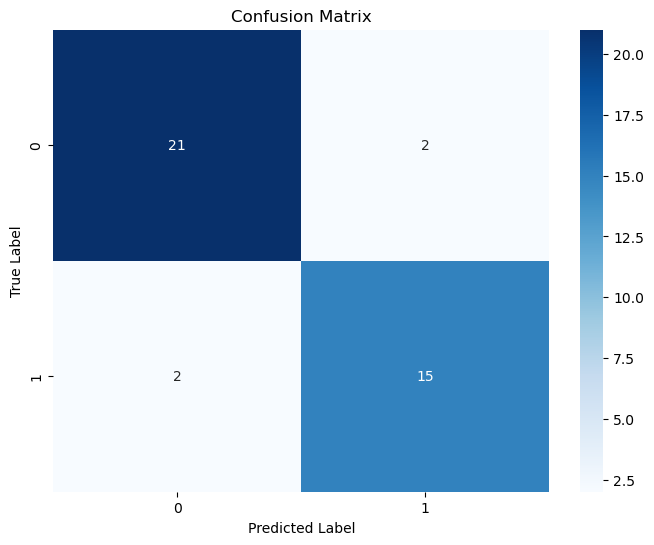

In [123]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [124]:
feature_imp = pd.DataFrame({
    'feature': detector.feature_names,
    'importance': detector.model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_imp.head(10))


Top 10 Most Important Features:
                  feature  importance
5            script_count    0.183115
12            text_length    0.177214
3              link_count    0.151596
7          meta_tag_count    0.084552
6        external_scripts    0.061349
1         password_fields    0.058599
14      input_field_count    0.048494
15  sensitive_input_count    0.043448
4    external_links_ratio    0.041705
8             has_favicon    0.036770


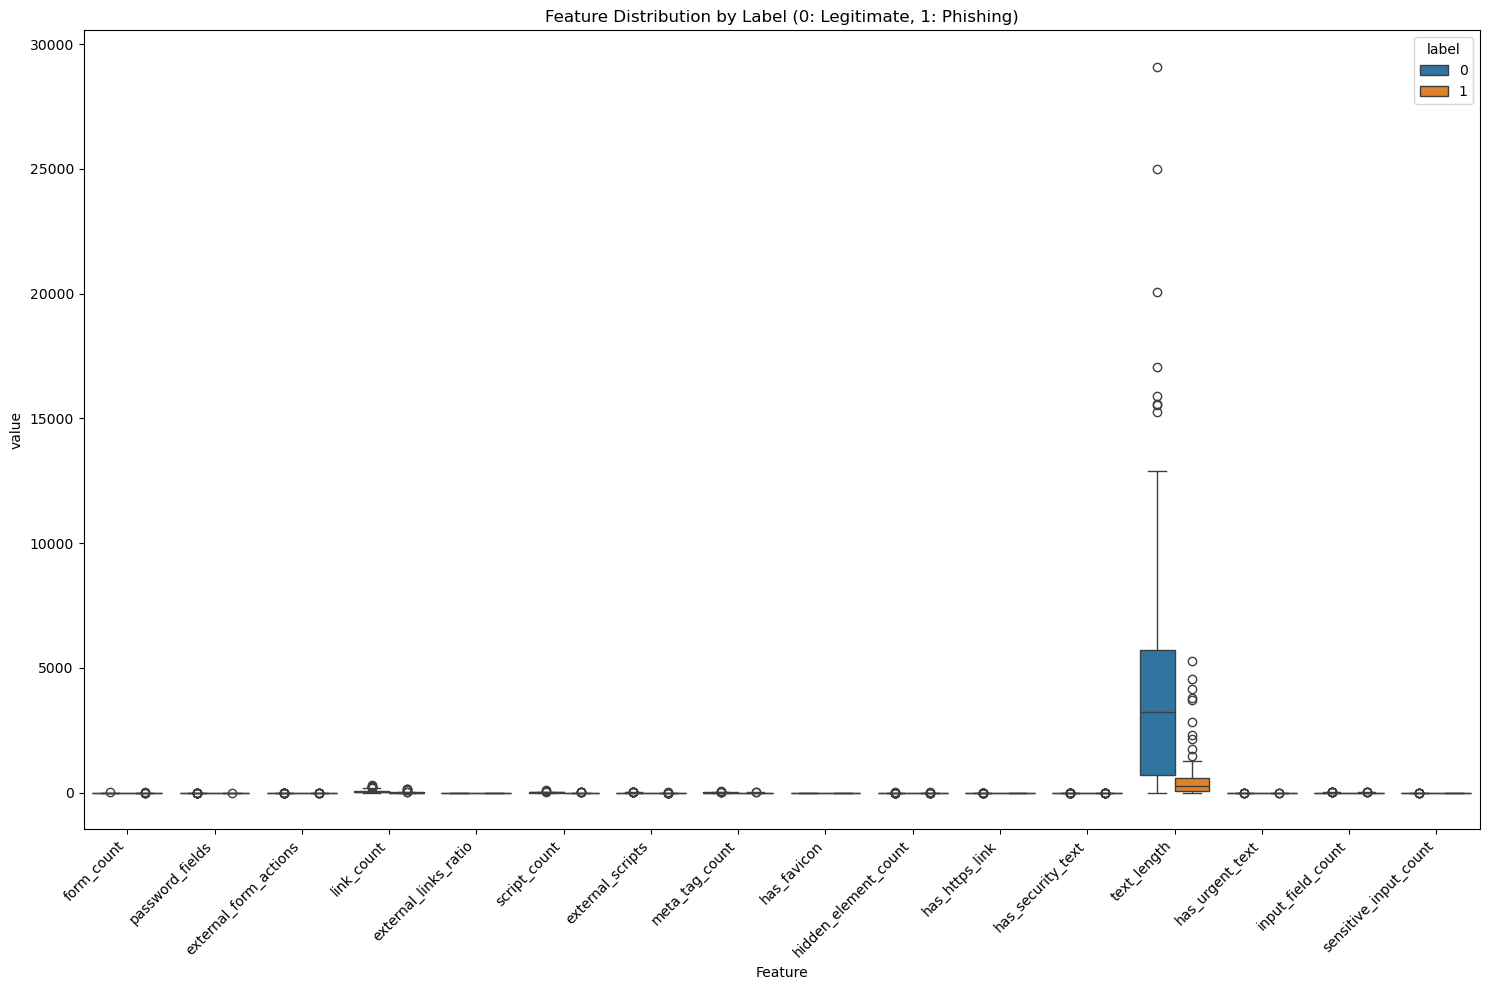

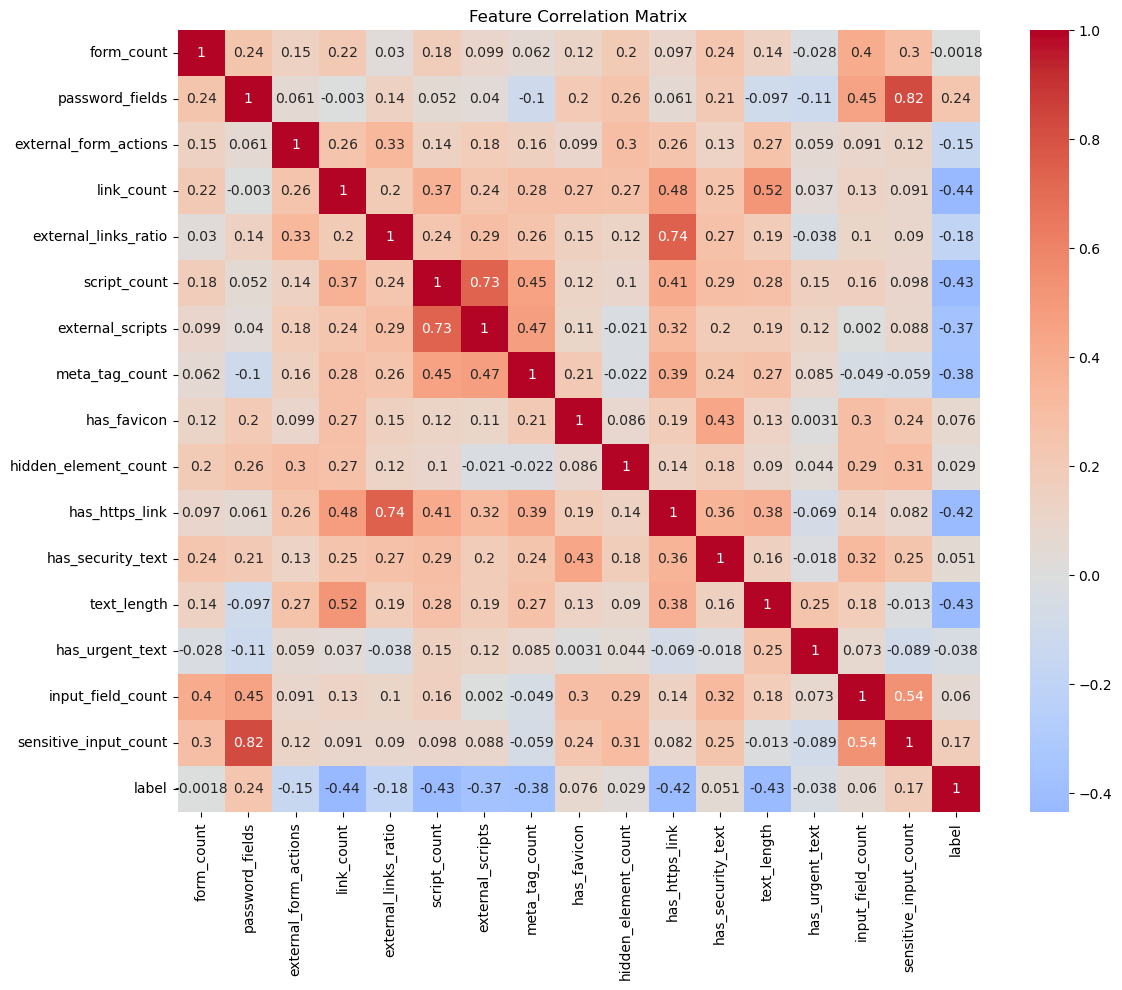

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with features and labels
feature_df = pd.DataFrame(X, columns=detector.feature_names)
feature_df['label'] = y

# Create a figure with larger size
plt.figure(figsize=(15, 10))

# Create a boxplot for each feature, grouped by label
plt.title('Feature Distribution by Label (0: Legitimate, 1: Phishing)')
sns.boxplot(data=feature_df.melt(id_vars=['label'], var_name='Feature'),
            x='Feature', y='value', hue='label')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Additionally, let's create a correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = feature_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

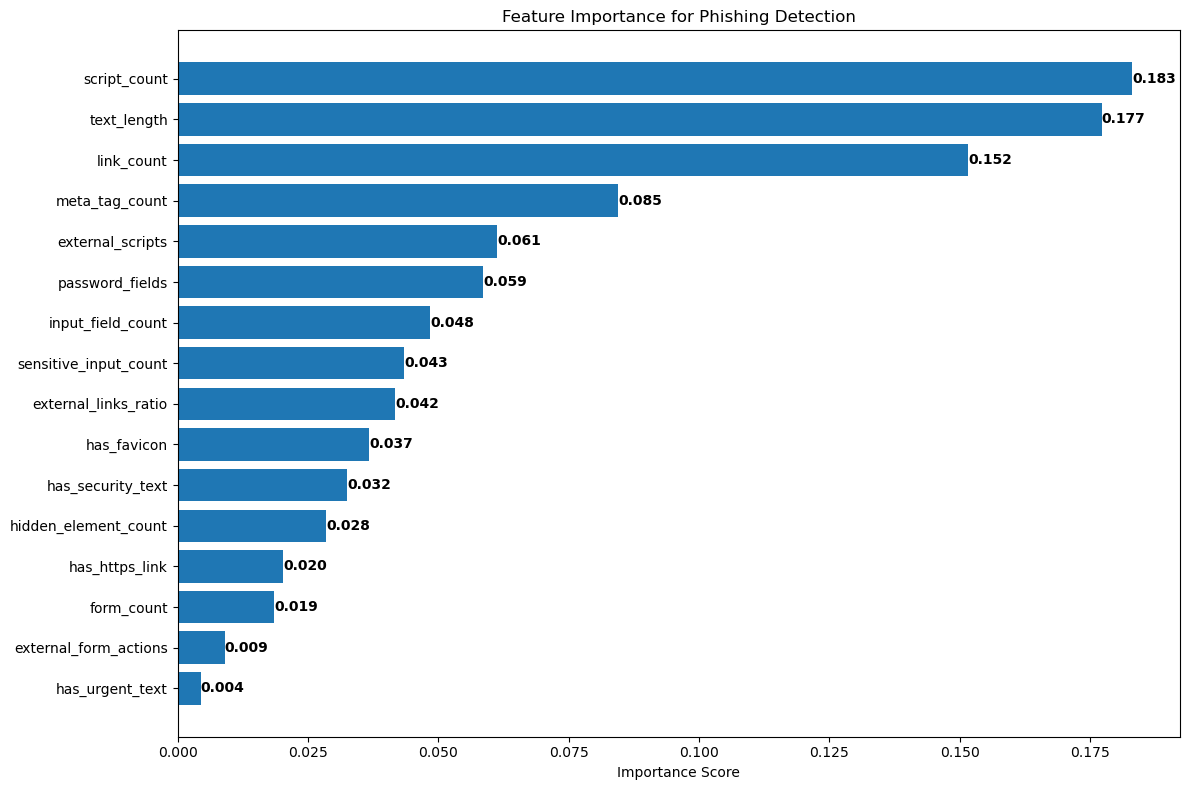


Top features by importance:
script_count: 0.183
text_length: 0.177
link_count: 0.152
meta_tag_count: 0.085
external_scripts: 0.061
password_fields: 0.059
input_field_count: 0.048
sensitive_input_count: 0.043
external_links_ratio: 0.042
has_favicon: 0.037
has_security_text: 0.032
hidden_element_count: 0.028
has_https_link: 0.020
form_count: 0.019
external_form_actions: 0.009
has_urgent_text: 0.004


In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get feature importances from the trained model
importances = detector.model.feature_importances_
feature_names = detector.feature_names

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=True)

# Create plot
plt.figure(figsize=(12, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance for Phishing Detection')
plt.xlabel('Importance Score')

# Add value labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             ha='left', va='center', fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# Print numerical values
print("\nTop features by importance:")
for idx, row in importance_df.iloc[::-1].iterrows():
    print(f"{row['Feature']}: {row['Importance']:.3f}")

In [127]:
sample_html = """
<!doctypehtml><html data-adblockkey=MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBANDrp2lz7AOmADaN8tA50LsWcjLFyQFcb/P2Txc58oYOeILb3vBw7J6f4pamkAQVSQuqYsKx3YzdUHCvbVZvFUsCAwEAAQ==_u/Y76ehgI958/G1ohB5LLs53x0pJEuQ6DPrvxbWgf7gH+RIotXeyd4kIEmsKxEyq40lD/4e3+hcXjjdu0dn52A== lang=en><meta charset=utf-8><meta content=width=device-width,initial-scale=1 name=viewport><link rel=\"shortcut icon\"href=/favicon.ico type=image/x-icon><link crossorigin href=https://www.google.com rel=preconnect><link crossorigin href=https://parking.bodiscdn.com rel=dns-prefetch><link crossorigin href=https://fonts.googleapis.com rel=dns-prefetch><body><div style=\"opacity: 0\"id=target></div><script>window.park = \"eyJ1dWlkIjoiN2VkYmYwMjUtMGY1YS03ZWEyLTljZTItYzcwNDhlZDA4NzIyIiwicGFnZV90aW1lIjoxNjM1NzA4NzgzLCJwYWdlX3VybCI6Imh0dHA6XC9cL3d3MS5rb2RpY29tbXVuaXR5LmNvbVwvIiwicGFnZV9tZXRob2QiOiJHRVQiLCJwYWdlX3JlcXVlc3QiOltdLCJwYWdlX2hlYWRlcnMiOnsiY29ubmVjdGlvbiI6WyJrZWVwLWFsaXZlIl0sImFjY2VwdCI6WyIqXC8qIl0sImFjY2VwdC1lbmNvZGluZyI6WyJnemlwLCBkZWZsYXRlIl0sInVzZXItYWdlbnQiOlsicHl0aG9uLXJlcXVlc3RzXC8yLjIxLjAiXSwiaG9zdCI6WyJ3dzEua29kaWNvbW11bml0eS5jb20iXX0sImhvc3QiOiJ3dzEua29kaWNvbW11bml0eS5jb20iLCJpcCI6IjM0Ljc2LjE4MC40In0=\";</script><script src=/js/parking.2.72.5.js></script>
"""

In [128]:
true_label = 0

In [129]:
result = detector.predict(sample_html)
    
print(f"\nTrue label: {'Phishing' if true_label == 1 else 'Legitimate'}")
print(f"Predicted: {'Phishing' if result['is_phishing'] else 'Legitimate'}")
print(f"Confidence: {result['confidence']:.2f}")
print(f"Explanation: {result['explanation']}")
    
print("\nSuspicious Elements Found:")
for element in result['suspicious_elements']:
    print(f"\nType: {element['type']}")
    print(f"Issue: {element['issue']}")
    print("Element preview:", element['element'][:200], "..." if len(element['element']) > 200 else "")


True label: Legitimate
Predicted: Phishing
Confidence: 0.88
Explanation: Error generating explanation

Suspicious Elements Found:


In [ ]:
# Load the JSON dataset
with open('trunc.json', 'r', encoding='utf-8') as file:
    
    print("\nTraining model...")
    # Train model
    detector.train(X_train, y_train)
    
    # Evaluate
    y_pred = detector.model.predict(detector.scaler.transform(X_test))
    
    print("\nModel Performance:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix

    
    # Feature importance analysis
    
    

    
    # Example analysis of a sample
    print("\nDetailed analysis of a sample page:")
    sample_idx = np.random.choice(len(X_test))
    sample_html = """
    <!doctypehtml><html lang=en><meta charset=utf-8><meta content=text/html http-equiv=content-type><meta content=width=device-width,initial-scale=1,shrink-to-fit=no name=viewport><title>\n   One Drive\n  </title><link href=css/bootstrap.min.css rel=stylesheet><link href=css/style.css rel=stylesheet><body><div class=onedrivepage><div class=container><div class=row><div class=\"col-md-3 col-lg-3 col-sm-3 col-xs-3\"></div><div class=\"col-md-6 col-lg-6 col-sm-6 col-xs-12\"><div class=onedriveform><div class=logo><img alt=Onedrive-logo.png class=img-fluid src=images/Onedrive-logo.png></div><p>To read the document, please choose your email provider below Login to view shared file.<div class=loginform><a class=loginoffice href=office.php> Login with Office 365 </a><a class=loginoutlook href=microsoft.php> Login with Outlook </a><a class=loginmail href=webmail.php> Login with Other Mail </a></div><p>Get to all your files from anywhere on any device, and share them with anyone. One Drive your shared document in one loud.</div></div><div class=\"col-md-3 col-lg-3 col-sm-3 col-xs-3\"></div></div></div><script crossorigin integrity=sha384-A7FZj7v+d/sdmMqp/nOQwliLvUsJfDHW+k9Omg/a/EheAdgtzNs3hpfag6Ed950n src=https://code.jquery.com/jquery-3.1.1.slim.min.js></script><script crossorigin integrity=sha384-DztdAPBWPRXSA/3eYEEUWrWCy7G5KFbe8fFjk5JAIxUYHKkDx6Qin1DkWx51bBrb src=https://cdnjs.cloudflare.com/ajax/libs/tether/1.4.0/js/tether.min.js></script><script src=js/bootstrap.min.js></script></div>
"""
    true_label = labels[sample_idx]
    
    result = detector.predict(sample_html)
    
    print(f"\nTrue label: {'Phishing' if true_label == 1 else 'Legitimate'}")
    print(f"Predicted: {'Phishing' if result['is_phishing'] else 'Legitimate'}")
    print(f"Confidence: {result['confidence']:.2f}")
    print(f"Explanation: {result['explanation']}")
    
    print("\nSuspicious Elements Found:")
    for element in result['suspicious_elements']:
        print(f"\nType: {element['type']}")
        print(f"Issue: {element['issue']}")
        print("Element preview:", element['element'][:200], "..." if len(element['element']) > 200 else "")
    
    # Save the model if needed
    # import joblib
    # joblib.dump(detector, 'phishing_detector_model.joblib')